In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

folder_path = 'images/'

In [20]:
df = pd.read_csv(folder_path + 'var_2.csv', index_col='ID').drop(columns=['Unnamed: 0'])
df.head()

,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,l knee_X,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
ID,,,,,,,,,,,,,,,,,,,,,
790,082581675.jpg,964,640,979,400,721,384,751,310,925,...,341,-1,-1,-1,-1,-1,-1,4.272067,"therapeutic exercise ball, Fitball exercise",conditioning exercise
791,012886987.jpg,1076,646,1054,392,787,363,818,301,1014,...,264,572,210,543,154,477,191,4.262146,"therapeutic exercise ball, Fitball exercise",conditioning exercise
792,033511885.jpg,465,484,417,279,597,323,632,418,352,...,196,860,293,688,355,562,302,4.651049,"therapeutic exercise ball, Fitball exercise",conditioning exercise
793,074350826.jpg,381,391,450,193,582,312,571,381,420,...,304,840,361,952,393,936,352,4.181514,"therapeutic exercise ball, Fitball exercise",conditioning exercise
794,016075990.jpg,383,563,402,428,555,532,579,588,407,...,301,532,328,459,490,344,512,5.066445,"therapeutic exercise ball, Fitball exercise",conditioning exercise


In [21]:
activities_count = df['Activity'].unique().shape[0]
categories_count = df['Category'].unique().shape[0]
keypoints_count = sum(col.endswith('X') or col.endswith('Y') for col in df.columns)
activities_count, categories_count, keypoints_count

(78, 19, 32)

In [22]:
label_encoder_activity = LabelEncoder()
labels_activity = df['Activity'].values
label_encoder_activity.fit(labels_activity)
df['Activity'] = label_encoder_activity.transform(df['Activity'])

label_encoder_category = LabelEncoder()
labels_category = df['Category'].values
label_encoder_category.fit(labels_category)
df['Category'] = label_encoder_category.transform(df['Category'])

In [23]:
activity_label_map = {index: label for index, label in enumerate(label_encoder_activity.classes_)}
category_label_map = {index: label for index, label in enumerate(label_encoder_category.classes_)}

In [24]:
imputed_df = df.copy()

keypoints_columns = imputed_df.columns[1:-3]

for index, row in imputed_df.iterrows():
    keypoints = row[keypoints_columns].astype(float).values
    for i in range(len(keypoints)):
        if keypoints[i] == -1:
            distances = cdist(keypoints.reshape(-1, 1), keypoints.reshape(-1, 1))
            closest_index = np.argmin(distances[np.where(keypoints != -1)])
            imputed_df.at[index, keypoints_columns[i]] = keypoints[closest_index]

In [25]:
imputed_df.head()

,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,l knee_X,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
ID,,,,,,,,,,,,,,,,,,,,,
790,082581675.jpg,964,640,979,400,721,384,751,310,925,...,341,964,964,964,964,964,964,4.272067,63,1
791,012886987.jpg,1076,646,1054,392,787,363,818,301,1014,...,264,572,210,543,154,477,191,4.262146,63,1
792,033511885.jpg,465,484,417,279,597,323,632,418,352,...,196,860,293,688,355,562,302,4.651049,63,1
793,074350826.jpg,381,391,450,193,582,312,571,381,420,...,304,840,361,952,393,936,352,4.181514,63,1
794,016075990.jpg,383,563,402,428,555,532,579,588,407,...,301,532,328,459,490,344,512,5.066445,63,1


In [26]:
def draw(points, image, activity, category):
    fig, ax = plt.subplots()

    ax.text(0, -10, f'Activity: {activity_label_map[activity]}', color='black', fontsize=10)
    ax.text(0, -70, f'Category: {category_label_map[category]}', color='black', fontsize=10)

    ax.imshow(image)

    keypoints_x = points[::2]
    keypoints_y = points[1::2]

    bones = [(0, 1), (1, 2), (2, 3), (3, 4), (2, 5), (5, 6), (6, 7), (7, 8),
             (2, 9), (9, 10), (10, 11), (11, 12), (2, 13), (13, 14), (14, 15), (15, 16)]

    for i in range(len(keypoints_x)):
        ax.scatter(keypoints_x[i], keypoints_y[i], color='red', marker='o')
        ax.text(keypoints_x[i], keypoints_y[i], str(i), color='white', fontsize=8, ha='center', va='center')

    for bone in bones:
        if bone[0] < len(keypoints_x) and bone[1] < len(keypoints_x):
            x_values = [keypoints_x[bone[0]], keypoints_x[bone[1]]]
            y_values = [keypoints_y[bone[0]], keypoints_y[bone[1]]]
            ax.plot(x_values, y_values, color='blue')

    ax.axis('off')

    plt.show()

In [27]:
class KeypointActivityDataset(Dataset):
    def __init__(self, csv_file, root_dir, size, transform=None):
        self.keypoints_frame = csv_file.copy()
        self.root_dir = root_dir
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.keypoints_frame)

    def __getitem__(self, idx):

        img_name = self.keypoints_frame.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        scale_x = self.size / image.width
        scale_y = self.size / image.height

        keypoints = self.keypoints_frame.iloc[idx, 1:-3].values.astype('float').copy()
        for i in range(keypoints.shape[0]):
            if keypoints[i] != -1:
                if i % 2 == 0:
                    keypoints[i] *= scale_x
                else:
                    keypoints[i] *= scale_y
        keypoints = torch.tensor(keypoints, dtype=torch.float32)

        activity_category = self.keypoints_frame.iloc[idx, -2:].copy()
        activity = torch.tensor(activity_category['Activity'], dtype=torch.long)
        category = torch.tensor(activity_category['Category'], dtype=torch.long)

        sample = {'image': image, 'keypoints': keypoints, 'activity': activity, 'category': category, 'scale_x': scale_x, 'scale_y': scale_y, 'img_path': img_path}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

In [28]:
size = 128
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
batch_size = 4

data = imputed_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_data, temp_data = train_test_split(data, test_size=(1 - train_ratio), random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

train_dataset = KeypointActivityDataset(train_data, folder_path, size, transform=transform)
val_dataset = KeypointActivityDataset(val_data, folder_path, size, transform=transform)
test_dataset = KeypointActivityDataset(test_data, folder_path, size, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
def train(model, train_loader, val_loader, optimizer, criterion_keypoints, criterion_activities, criterion_categories, num_epochs):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in tqdm(train_loader):
            inputs, keypoints, activities, categories = data['image'].to(device), data['keypoints'].to(device), data['activity'].to(device), data['category'].to(device)

            optimizer.zero_grad()

            keypoints_pred, activities_pred, categories_pred = model(inputs)
            loss_keypoints = criterion_keypoints(keypoints_pred, keypoints)
            loss_activities = criterion_activities(activities_pred, activities)
            loss_categories = criterion_categories(categories_pred, categories)

            loss = loss_keypoints + loss_activities + loss_categories

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_epoch_loss = running_loss/len(train_loader)
        train_losses.append(train_epoch_loss)
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for data in tqdm(val_loader):
                inputs, keypoints, activities, categories = data['image'].to(device), data['keypoints'].to(device), data['activity'].to(device), data['category'].to(device)

                keypoints_pred, activities_pred, categories_pred = model(inputs)

                loss_keypoints = criterion_keypoints(keypoints_pred, keypoints)
                loss_activities = criterion_activities(activities_pred, activities)
                loss_categories = criterion_categories(categories_pred, categories)

                loss = loss_keypoints + loss_activities + loss_categories

                val_loss += loss.item()

            val_epoch_loss = val_loss/len(val_loader)
            val_losses.append(val_epoch_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_epoch_loss:.4f}, Val loss: {val_epoch_loss:.4f}")

    return model, train_losses, val_losses

In [30]:
def predict(model, loader):

    all_predictions = {'pred_keypoints': [], 'pred_activities': [], 'pred_categories': [], 'true_keypoints': [], 'true_activities': [], 'true_categories': [], 'inputs': []}

    model.eval()
    with torch.no_grad():
        for data in tqdm(loader):
            inputs, keypoints, activities, categories, scale_x, scale_y, img_path = data['image'].to(device), data['keypoints'], data['activity'], data['category'], data['scale_x'], data['scale_y'], data['img_path']

            keypoints_pred, activities_pred, categories_pred = model(inputs)
            keypoints_pred = keypoints_pred.detach().cpu().numpy().copy()
            for i in range(keypoints_pred.shape[0]):
                for j in range(keypoints_pred.shape[1]):
                    if keypoints_pred[i][j] != -1:
                        if j % 2 == 0:
                            keypoints_pred[i][j] /= scale_x[i]
                        else:
                            keypoints_pred[i][j] /= scale_y[i]
            for i in range(keypoints.shape[0]):
                for j in range(keypoints.shape[1]):
                    if keypoints[i][j] != -1:
                        if j % 2 == 0:
                            keypoints[i][j] /= scale_x[i]
                        else:
                            keypoints[i][j] /= scale_y[i]

            all_predictions['pred_keypoints'].append(keypoints_pred)
            all_predictions['pred_activities'].append(activities_pred.argmax(dim=1).cpu().numpy())
            all_predictions['pred_categories'].append(categories_pred.argmax(dim=1).cpu().numpy())
            all_predictions['true_keypoints'].append(keypoints.numpy())
            all_predictions['true_activities'].append(activities.numpy())
            all_predictions['true_categories'].append(categories.numpy())
            all_predictions['inputs'].append(img_path)

    for key in all_predictions.keys():
        all_predictions[key] = np.concatenate(all_predictions[key])

    return all_predictions

In [31]:
def calculate_metrics(keypoints_true, keypoints_pred, activities_true, activities_pred, categories_true, categories_pred, loader_type):
    mse_keypoints = mean_squared_error(keypoints_true, keypoints_pred)
    rmse_keypoints = np.sqrt(mse_keypoints)
    mae_keypoints = np.mean(np.abs(keypoints_true - keypoints_pred))

    accuracy_activities = accuracy_score(activities_true, activities_pred)
    precision_activities = precision_score(activities_true, activities_pred, average='weighted', zero_division=0)
    recall_activities = recall_score(activities_true, activities_pred, average='weighted', zero_division=0)
    f1_activities = f1_score(activities_true, activities_pred, average='weighted')

    accuracy_categories = accuracy_score(categories_true, categories_pred)
    precision_categories = precision_score(categories_true, categories_pred, average='weighted', zero_division=0)
    recall_categories = recall_score(categories_true, categories_pred, average='weighted', zero_division=0)
    f1_categories = f1_score(categories_true, categories_pred, average='weighted')

    mtl_score = (accuracy_activities + accuracy_categories) / 2

    print(f"Metrics for {loader_type}:\nKeypoint MSE: {mse_keypoints},\nKeypoint RMSE: {rmse_keypoints},\nKeypoint MAE: {mae_keypoints},\nActivity Accuracy: {accuracy_activities},\nActivity Precision: {precision_activities},\nActivity Recall: {recall_activities},\nActivity F1-score: {f1_activities},\nCategory Accuracy: {accuracy_categories},\nCategory Precision: {precision_categories},\nCategory Recall: {recall_categories},\nCategory F1-score: {f1_categories},\nMTL Score: {mtl_score}")

In [32]:
def validate(model, loader, images_to_draw, loader_type):
    predictions = predict(model, loader)

    calculate_metrics(predictions['true_keypoints'], predictions['pred_keypoints'], predictions['true_activities'],
                      predictions['pred_activities'], predictions['true_categories'], predictions['pred_categories'], loader_type)

    for i in range(images_to_draw):
        file_path = predictions['inputs'][i]
        image = Image.open(file_path)
        draw(predictions['pred_keypoints'][i], image, predictions['pred_activities'][i], predictions['pred_categories'][i])

In [33]:
class KeypointActivityModel(nn.Module):
    def __init__(self, num_keypoints, num_activities, num_categories):
        super(KeypointActivityModel, self).__init__()

        self.backbone = models.resnet50(weights='IMAGENET1K_V2')

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.keypoint_fc = nn.Linear(1000, num_keypoints)

        self.activity_fc = nn.Linear(1000, num_activities)

        self.category_fc = nn.Linear(1000, num_categories)

    def forward(self, x):
        features = self.backbone(x)

        keypoints = self.keypoint_fc(features)
        activities = self.activity_fc(features)
        categories = self.category_fc(features)

        return keypoints, activities, categories

In [50]:
model = KeypointActivityModel(keypoints_count, activities_count, categories_count).to(device)

In [51]:
learning_rate = 0.001
num_epochs = 1
criterion_keypoints = nn.MSELoss()
criterion_activities = nn.CrossEntropyLoss()
criterion_categories = nn.CrossEntropyLoss()

optimizer = optim.Adamax(model.parameters(), lr=learning_rate)

In [58]:
model, train_losses, val_losses = train(model, train_loader, val_loader, optimizer, criterion_keypoints, criterion_activities, criterion_categories, num_epochs)

100%|██████████| 30/30 [00:01<00:00, 17.20it/s]


Epoch [1/100], Train loss: 1042.5917, Val loss: 3462.2425


100%|██████████| 30/30 [00:01<00:00, 17.67it/s]


Epoch [2/100], Train loss: 1028.4956, Val loss: 1976.3195


 10%|█         | 14/138 [00:01<00:09, 13.55it/s]


KeyboardInterrupt: 

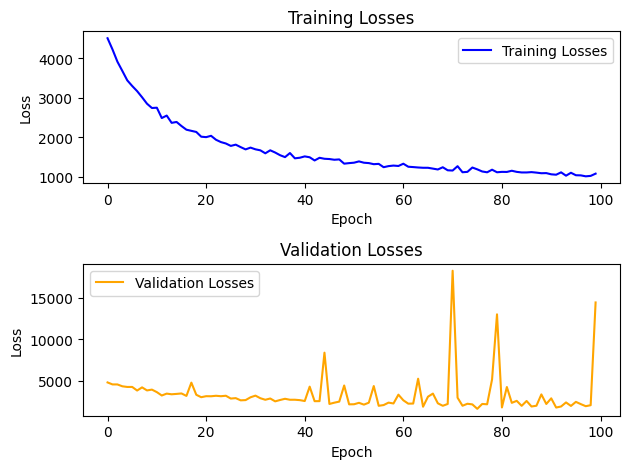

In [59]:
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
torch.save(model.state_dict(), "model.pth")

In [61]:
model = KeypointActivityModel(num_keypoints=keypoints_count, num_activities=activities_count, num_categories=categories_count).to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

100%|██████████| 30/30 [00:02<00:00, 14.54it/s]


Metrics for validation:
Keypoint MSE: 142626.296875,
Keypoint RMSE: 377.6589660644531,
Keypoint MAE: 293.121826171875,
Activity Accuracy: 0.6694915254237288,
Activity Precision: 0.6226531942633637,
Activity Recall: 0.6694915254237288,
Activity F1-score: 0.6184804712845591,
Category Accuracy: 0.6694915254237288,
Category Precision: 0.6814290758676351,
Category Recall: 0.6694915254237288,
Category F1-score: 0.6642574948782598,
MTL Score: 0.6694915254237288


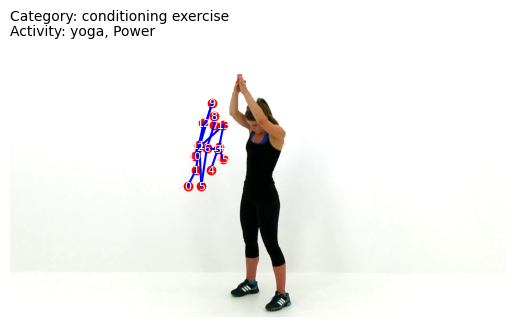

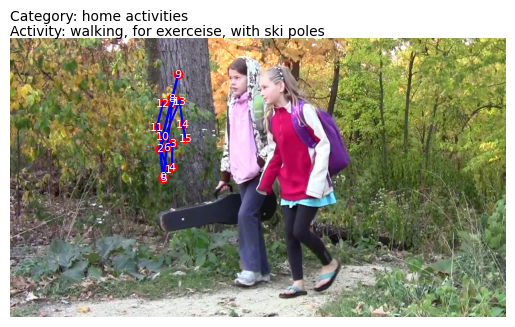

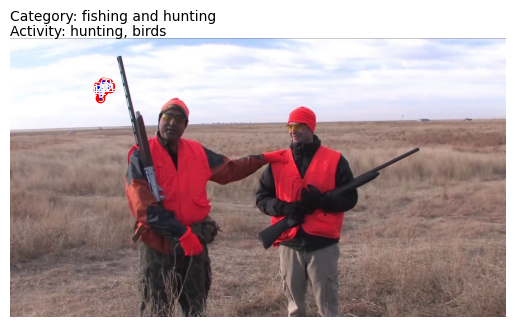

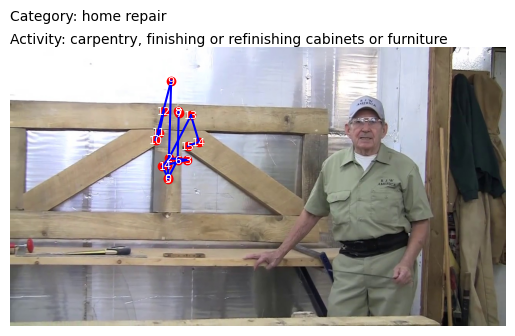

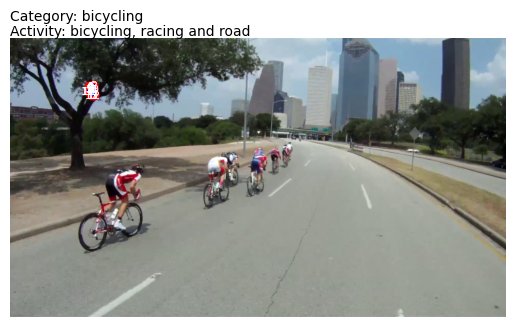

In [62]:
validate(model, val_loader, 5, 'validation')

100%|██████████| 30/30 [00:01<00:00, 15.04it/s]


Metrics for testing:
Keypoint MSE: 127688.3359375,
Keypoint RMSE: 357.3350524902344,
Keypoint MAE: 283.4067687988281,
Activity Accuracy: 0.7142857142857143,
Activity Precision: 0.7201898150564573,
Activity Recall: 0.7142857142857143,
Activity F1-score: 0.686424454839407,
Category Accuracy: 0.7563025210084033,
Category Precision: 0.7470613541859431,
Category Recall: 0.7563025210084033,
Category F1-score: 0.7354153475108239,
MTL Score: 0.7352941176470589


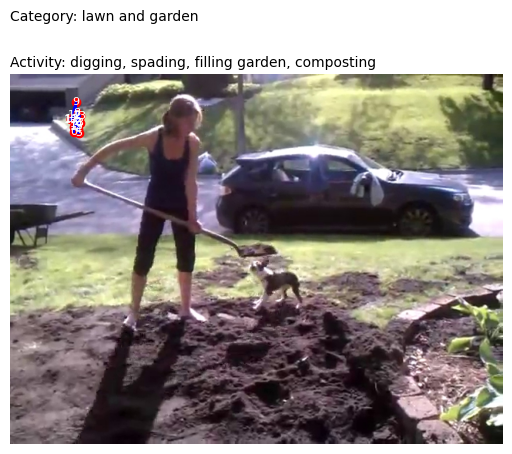

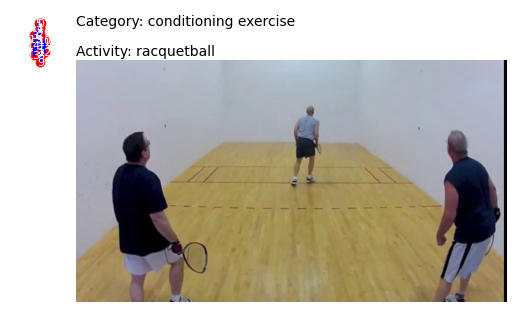

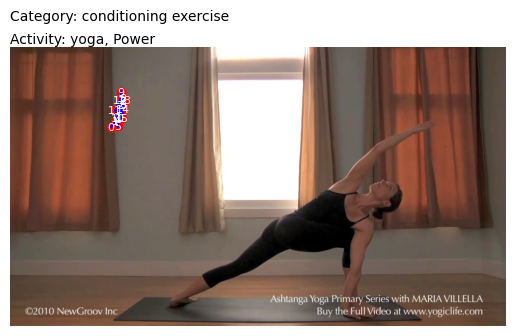

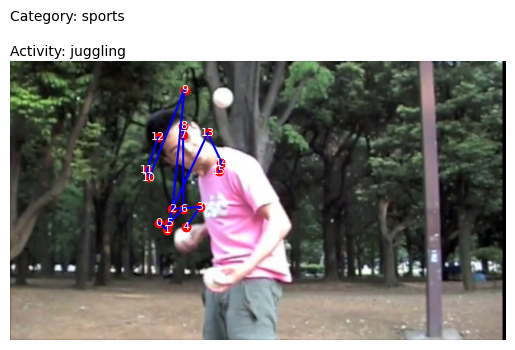

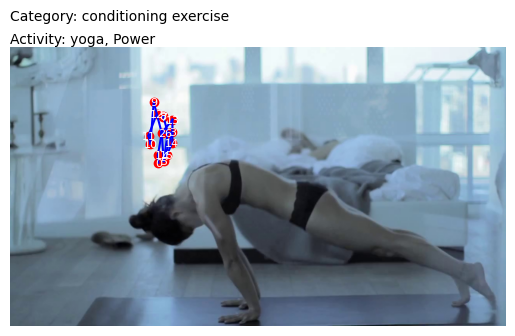

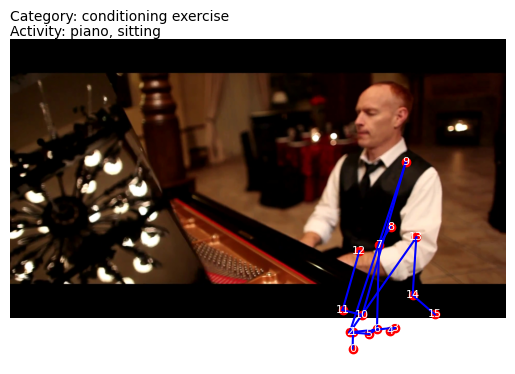

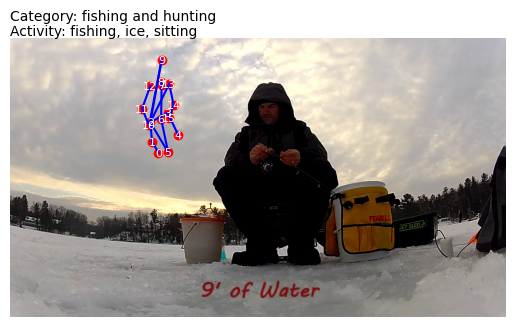

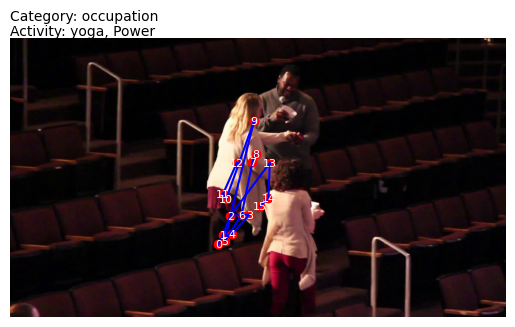

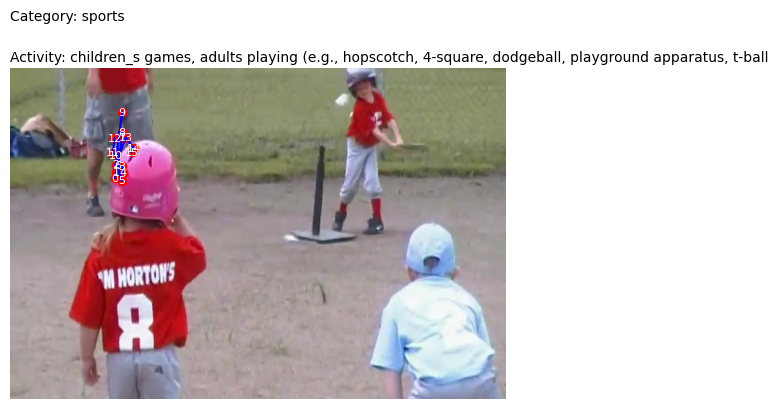

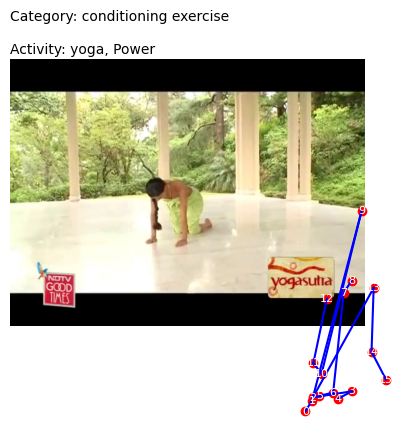

In [63]:
validate(model, test_loader, 10, 'testing')